# Value Investor

- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: May 10, 2023

## Import libraries & Data

In [1]:
import zipfile

local_zip = './data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os

filenames = os.listdir('data')

# We will store the stock data for all companies by their company code
stock_dfs = {}

In [4]:
def get_company_code(name):
  return name[name.find("(")+1:name.find(")")]

get_company_code('2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv')

'PAMP'

In [5]:
for fname in filenames:
  stock_dfs[get_company_code(fname)] = pd.read_csv(os.path.join('./data', fname))

In [6]:
stock_dfs['PAMP'].head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",85.15,86.5,88.1,85.15,564.30K,-1.10%
1,"Mar 30, 2021",86.1,85.15,86.75,84.6,141.40K,1.29%
2,"Mar 29, 2021",85,80,86,79,371.22K,3.85%
3,"Mar 26, 2021",81.85,84,84.6,80.7,462.55K,-2.09%
4,"Mar 25, 2021",83.6,85.2,87.3,82.1,389.78K,-3.13%


In [7]:
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      301 non-null    object
 1   Price     301 non-null    object
 2   Open      301 non-null    object
 3   High      301 non-null    object
 4   Low       301 non-null    object
 5   Vol.      300 non-null    object
 6   Change %  300 non-null    object
dtypes: object(7)
memory usage: 16.6+ KB


## Data Preprocessing

We notice that the last row of the datasets stores a summary of the stock price change which should be discarded for modelling in the future.

In [8]:
stock_dfs['PAMP'].tail()

,Date,Price,Open,High,Low,Vol.,Change %
296,"Jan 07, 2020",47.6,48.35,49,46.9,901.95K,-1.86%
297,"Jan 06, 2020",48.5,48.4,48.7,47,719.24K,-0.61%
298,"Jan 03, 2020",48.8,48.25,49.45,46.5,595.36K,1.14%
299,"Jan 02, 2020",48.25,49.35,50.2,47.55,878.50K,-2.92%
300,Highest: 90.000,Lowest: 32.000,Difference: 58.000,Average: 61.244,Change %: 71.328,NaN,NaN


In [9]:
for code in stock_dfs:
  df = stock_dfs[code]
  df.drop(df.tail(1).index,inplace=True)

In [10]:
# The last row is successfully removed
stock_dfs['PAMP'].tail()

,Date,Price,Open,High,Low,Vol.,Change %
295,"Jan 08, 2020",46.5,47.5,47.5,46,1.18M,-2.31%
296,"Jan 07, 2020",47.6,48.35,49,46.9,901.95K,-1.86%
297,"Jan 06, 2020",48.5,48.4,48.7,47,719.24K,-0.61%
298,"Jan 03, 2020",48.8,48.25,49.45,46.5,595.36K,1.14%
299,"Jan 02, 2020",48.25,49.35,50.2,47.55,878.50K,-2.92%


Now we need to convert the `Price` to numerical representation.

In [11]:
for code in stock_dfs:
  df = stock_dfs[code]
  df['Price'] = df['Price'].apply(lambda x: float(''.join(x.split(','))))

We notice that the `Date` is currently stored as string. It might be helpful to convert them into datetime for further uses.

In [12]:
from datetime import datetime

for code in stock_dfs:
  df = stock_dfs[code]
  df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

In [13]:
# the Date column has successfully been transformed
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      300 non-null    datetime64[ns]
 1   Price     300 non-null    float64       
 2   Open      300 non-null    object        
 3   High      300 non-null    object        
 4   Low       300 non-null    object        
 5   Vol.      300 non-null    object        
 6   Change %  300 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 16.5+ KB


To represent the dates numerically, we can calculate how many days after was a data point recorded from the baseline date, for which we will choose Jan 1, 2020.

In [14]:
for code in stock_dfs:
  df = stock_dfs[code]
  df['date_diff'] = df['Date'].apply(lambda x: (x - datetime.strptime('Jan 01, 2020', '%b %d, %Y')).days)
  df.sort_values(by='date_diff', ascending=True, inplace=True)

In [15]:
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 299 to 0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       300 non-null    datetime64[ns]
 1   Price      300 non-null    float64       
 2   Open       300 non-null    object        
 3   High       300 non-null    object        
 4   Low        300 non-null    object        
 5   Vol.       300 non-null    object        
 6   Change %   300 non-null    object        
 7   date_diff  300 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 21.1+ KB


Now we can visualize how the price changed for each company.

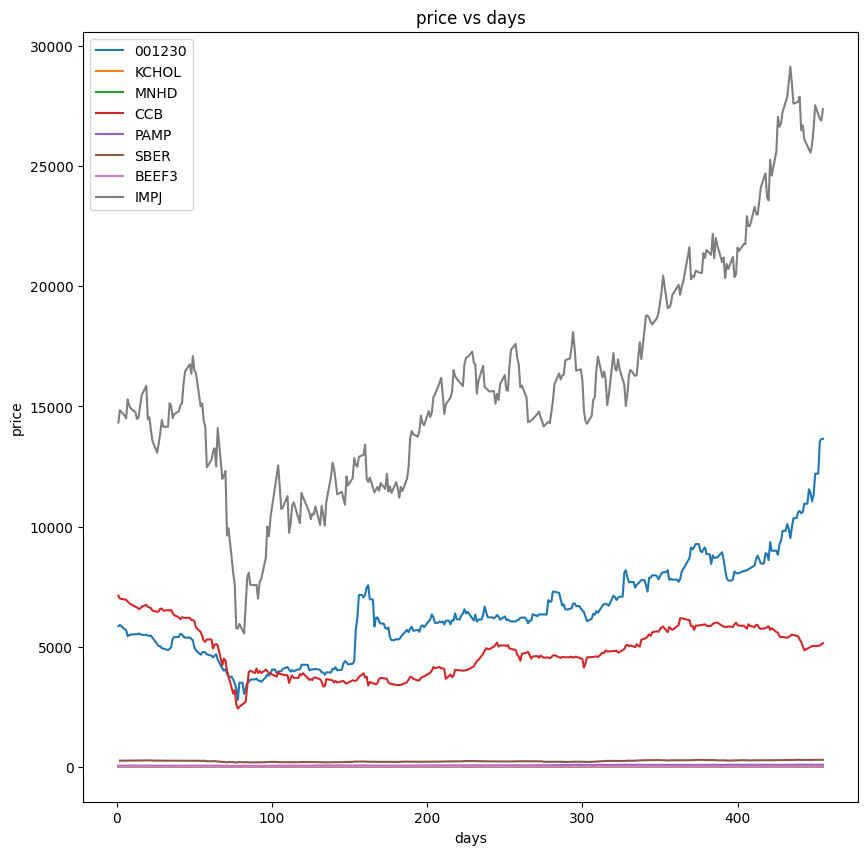

In [16]:
plt.figure(figsize=(10,10))

for code in stock_dfs:
  df = stock_dfs[code]
  plt.plot(df['date_diff'], df['Price'], label = code)

plt.xlabel('days')
plt.ylabel('price')
plt.title('price vs days')
plt.legend()
plt.show()

Out of the 8 stocks that we have, IMPJ, 001230 and CCB are significantly more expensive comparing to the others. We can exclude these 3 and see how the others perform.

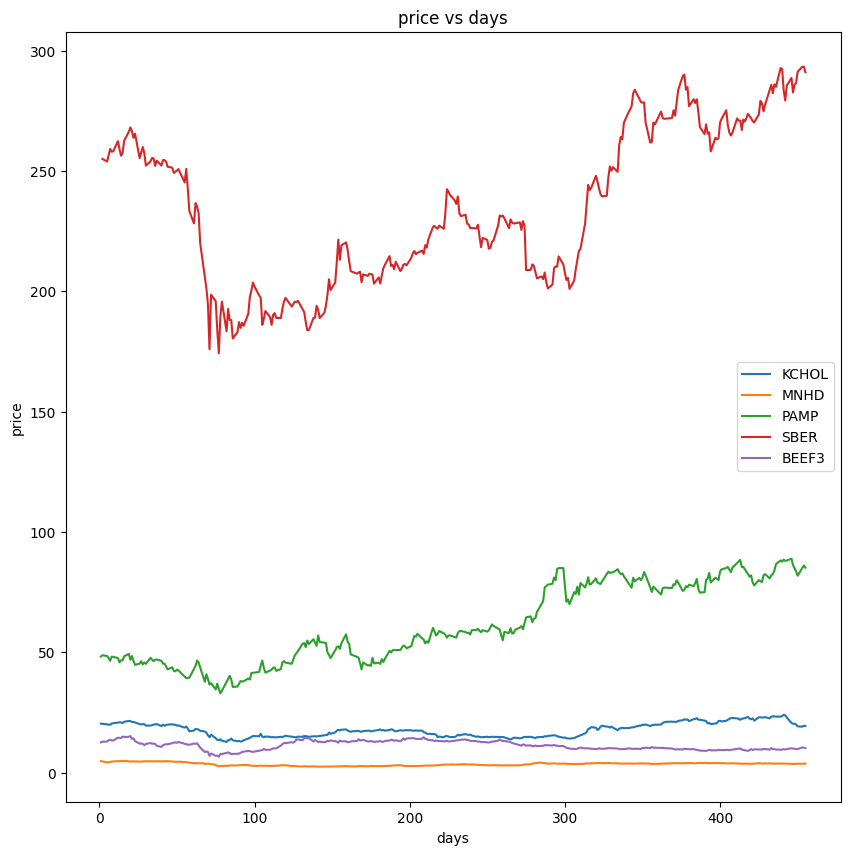

In [17]:
plt.figure(figsize=(10,10))

for code in stock_dfs:
  if code in ['IMPJ', '001230', 'CCB']:
    continue
  df = stock_dfs[code]
  plt.plot(df['date_diff'], df['Price'], label = code)

plt.xlabel('days')
plt.ylabel('price')
plt.title('price vs days')
plt.legend()
plt.show()

It seems that MNHD is performing stably at the low price range that is below 5 whereas the other stocks flunctuates a bit more.

We will pick 'PAMP' for our initial attempt of modelling.

## Preparing the datasets

In [18]:
from pandas.core import window
# We will define a helper function to transform our data into batches padded to the same length
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

# Training set: price from 2020, Testing set: price from 2021
def train_test_split(df):
  series = df['Price']

  # Get the index of the first data point in 2021
  idx_2021 = df['Date'].apply(lambda x: x.year == 2021).argmax()

  time_train = df['Date'].values[:idx_2021]
  time_test = df['Date'].values[idx_2021:]

  train_set = series[:idx_2021].values
  test_set = series[idx_2021-WINDOW_SIZE:].values

  return idx_2021, time_train, train_set, time_test, test_set

df = stock_dfs['PAMP']
idx_2021, time_train, train_set, time_test, test_set = train_test_split(df)

In [19]:
def windowing(series, window_size = WINDOW_SIZE):
    data = []
    labels = []

    series = series.reshape(-1, 1)

    for i in range(len(series)-window_size):
      data.append(series[i:i+window_size])
      labels.append(series[i+window_size])

    return np.array(data), np.array(labels)

train_data, train_labels = windowing(train_set)
test_data, test_labels = windowing(test_set)

In [20]:
# def windowed_dataset(input, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
#     dataset = tf.data.Dataset.from_tensor_slices(input)
#     dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#     dataset = dataset.shuffle(shuffle_buffer)
#     dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#     dataset = dataset.batch(batch_size).prefetch(1)
#     return dataset

In [21]:
import tensorflow as tf

# Convert training dataset to tf dataset
train = tf.convert_to_tensor(train_data)
test = tf.convert_to_tensor(test_data)

In [22]:
# train = windowed_dataset(train)
# test = windowed_dataset(test)

## Modelling by Moving Average

In [23]:
def pred_MA(series, window_size=WINDOW_SIZE, output_length=60):
  y_pred = list(series[-window_size:])
  for i in range(output_length):
    y_pred.append(sum(y_pred[-window_size:])/window_size)

  return y_pred[-output_length:]

y_pred = pred_MA(train_set, output_length=len(time_test))
y_true = df.Price[idx_2021:].values

In [24]:
# We will evaluate the predictions by MAE
def MAE(y_true, y_pred):
  return np.sum(np.abs(y_pred - y_true))/len(y_true)

In [25]:
print(f'Moving Average MAE: {MAE(y_true, y_pred)}')

Moving Average MAE: 4.058691044042326


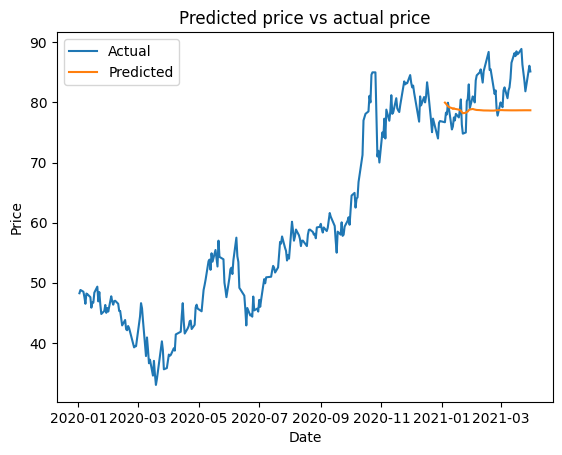

In [26]:
plt.figure()
plt.plot(df['Date'], df['Price'], label='Actual')
plt.plot(time_test, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted price vs actual price')
plt.legend()
plt.show()

## Modelling with RNN

To construct a model for the dataset, we firstly need to build a data pipe that could feed the input data to the model.

In [27]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[WINDOW_SIZE, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-traina

In [28]:
history = model.fit(x=train_data, y=train_labels, epochs=70)

Epoch 1/70
7/7 [==============================] - 11s 59ms/step - loss: 56.1527
Epoch 2/70
7/7 [==============================] - 0s 74ms/step - loss: 54.3424
Epoch 3/70
7/7 [==============================] - 0s 66ms/step - loss: 52.3352
Epoch 4/70
7/7 [==============================] - 1s 91ms/step - loss: 50.0166
Epoch 5/70
7/7 [==============================] - 1s 83ms/step - loss: 47.3340
Epoch 6/70
7/7 [==============================] - 1s 88ms/step - loss: 44.4478
Epoch 7/70
7/7 [==============================] - 1s 84ms/step - loss: 41.4051
Epoch 8/70
7/7 [==============================] - 0s 62ms/step - loss: 38.0572
Epoch 9/70
7/7 [==============================] - 0s 54ms/step - loss: 34.3462
Epoch 10/70
7/7 [==============================] - 0s 51ms/step - loss: 30.2430
Epoch 11/70
7/7 [==============================] - 0s 64ms/step - loss: 25.6861
Epoch 12/70
7/7 [==============================] - 0s 66ms/step - loss: 20.7387
Epoch 13/70
7/7 [==============================]

In [29]:
def pred_RNN(data, model, window_size=WINDOW_SIZE, output_length=60):
  input = data[-1]

  predictions = []

  for i in range(output_length):
    prediction = model.predict(input)
    predictions.append(prediction[-1])
    input = np.append(input, prediction[-1])
    input = input[1:].reshape(-1,1)

  return predictions

In [30]:
y_pred = np.array(pred_RNN(train_data, model)).flatten()

1/1 [==============================] - 0s 45ms/step


Now let's compare our prediction to the actual data.

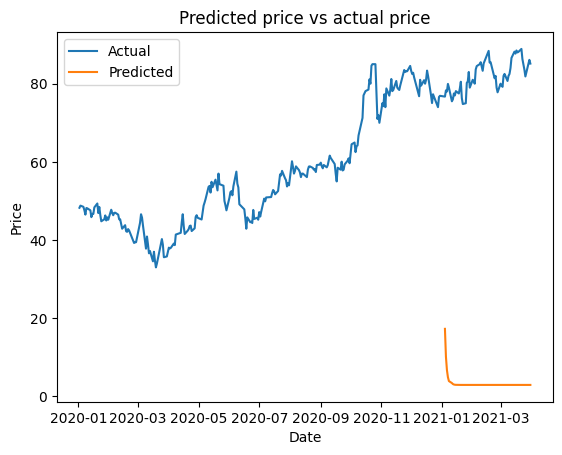

In [31]:
plt.figure()
plt.plot(df['Date'], df['Price'], label='Actual')
plt.plot(time_test, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted price vs actual price')
plt.legend()
plt.show()

In [32]:
print(f'RNN MAE: {MAE(y_true, y_pred)}')

RNN MAE: 78.47309868097305


## Modelling with Prophet

In [33]:
!pip install prophet

In [56]:
from prophet import Prophet

def pred_prophet(df, forecast_length=60):

  temp_df = df[df['Date'].apply(lambda x: x.year < 2021)][['Date', 'Price']].copy()
  temp_df.rename({'Date': 'ds', 'Price': 'y'}, axis='columns', inplace=True)

  m = Prophet(daily_seasonality=True)
  m.fit(temp_df)
  future = m.make_future_dataframe(periods=forecast_length)
  forecast = m.predict(future)
  temp_df = pd.DataFrame(data={'ds': future['ds'], 'y': forecast['yhat']})
  pd.options.display.max_columns = None

  return temp_df, m, forecast['yhat']

temp_df, m, forecast = pred_prophet(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/_zh9wmlz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/dpk79fbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56757', 'data', 'file=/tmp/tmpj4c7mva_/_zh9wmlz.json', 'init=/tmp/tmpj4c7mva_/dpk79fbh.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modelaxml0y90/prophet_model-20230629162105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
y_pred = forecast[idx_2021:]

In [36]:
print(f'Prophet MAE: {MAE(y_true, y_pred)}')

Prophet MAE: 9.909939900161586


### Making Predictions

As moving average achieved the lowest MAE, we will finalize our prediction approach to be Moving Average.

In [37]:
predictions = pred_MA(train_set, output_length=len(time_test))
predictions = pred_MA(train_set, output_length=len(time_test))

In [38]:
pred_df = df[idx_2021-WINDOW_SIZE:].copy()
pred_df['Price'][WINDOW_SIZE:] = predictions
pred_df.tail()

<ipython-input-38-f426f85fe48f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][WINDOW_SIZE:] = predictions


,Date,Price,Open,High,Low,Vol.,Change %,date_diff
4,2021-03-25,78.693005,85.2,87.3,82.1,389.78K,-3.13%,449
3,2021-03-26,78.693918,84,84.6,80.7,462.55K,-2.09%,450
2,2021-03-29,78.693863,80,86,79,371.22K,3.85%,453
1,2021-03-30,78.693142,85.15,86.75,84.6,141.40K,1.29%,454
0,2021-03-31,78.691831,86.5,88.1,85.15,564.30K,-1.10%,455


In [39]:
pred_df['MA'] = pred_df['Price'].rolling(WINDOW_SIZE).mean()
pred_df['SD'] = pred_df['Price'].rolling(WINDOW_SIZE).std()
pred_df['UpperBand'] = pred_df['MA'] + (pred_df['SD'])
pred_df['LowerBand'] = pred_df['MA'] - (pred_df['SD'])

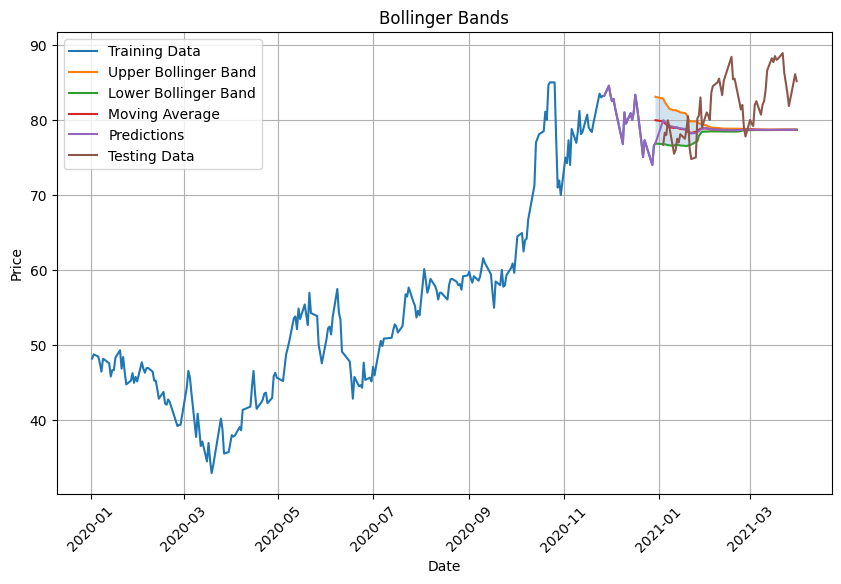

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(df[:idx_2021]['Date'], df[:idx_2021]['Price'], label='Training Data')
plt.plot(pred_df['Date'], pred_df['UpperBand'], label='Upper Bollinger Band')
plt.plot(pred_df['Date'], pred_df['LowerBand'], label='Lower Bollinger Band')
plt.plot(pred_df['Date'], pred_df['MA'], label='Moving Average')
plt.plot(pred_df['Date'], pred_df['Price'], label='Predictions')
plt.plot(df[idx_2021:]['Date'], df[idx_2021:]['Price'], label='Testing Data')
plt.fill_between(pred_df['Date'], pred_df['LowerBand'], pred_df['UpperBand'], alpha=0.2)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [41]:
pred_df['true_price'] = df[idx_2021:]['Price']
pred_df = pred_df[WINDOW_SIZE:]
pred_df.insert(0, 'Recommendation', 'Hold')

In [42]:
pred_df['Recommendation'].where(pred_df['true_price'] <= pred_df['UpperBand'], 'Sell', inplace=True)
pred_df['Recommendation'].where(pred_df['true_price'] >= pred_df['LowerBand'], 'Buy', inplace=True)
pred_df.head()

,Recommendation,Date,Price,Open,High,Low,Vol.,Change %,date_diff,MA,SD,UpperBand,LowerBand,true_price
59,Buy,2021-01-04,79.967500,76.9,78.1,76,463.28K,-0.26%,369,79.805875,3.025983,82.831858,76.779892,76.70
58,Hold,2021-01-05,79.805875,76.65,78.9,76.2,500.06K,2.09%,370,79.568669,2.812966,82.381635,76.755702,78.30
57,Hold,2021-01-06,79.568669,77.6,78.9,77,175.53K,-0.38%,371,79.382102,2.672706,82.054809,76.709396,78.00
56,Hold,2021-01-07,79.382102,76.6,80.4,76.6,414.26K,2.50%,372,79.226207,2.570239,81.796447,76.655968,79.95
55,Hold,2021-01-08,79.226207,79.45,79.9,76.3,836.37K,-1.19%,373,79.047518,2.429055,81.476573,76.618462,79.00


Let's put them into a helper function.

In [64]:
def generate_predictions_and_recommendations(df, predictions, window_size=WINDOW_SIZE, code=''):
  pred_df = df[idx_2021-window_size:].copy()

  pred_df['Price'][window_size:] = predictions
  pred_df['MA'] = pred_df['Price'].rolling(window_size).mean()
  pred_df['SD'] = pred_df['Price'].rolling(window_size).std()
  pred_df['UpperBand'] = pred_df['MA'] + 2*(pred_df['SD'])
  pred_df['LowerBand'] = pred_df['MA'] - 2*(pred_df['SD'])

  plt.figure(figsize=(10, 6))
  plt.plot(df[:idx_2021]['Date'], df[:idx_2021]['Price'], label='Training Data')
  plt.plot(pred_df['Date'], pred_df['UpperBand'], label='Upper Bollinger Band')
  plt.plot(pred_df['Date'], pred_df['LowerBand'], label='Lower Bollinger Band')
  plt.plot(pred_df['Date'], pred_df['MA'], label='Moving Average')
  plt.plot(pred_df['Date'], pred_df['Price'], label='Predictions')
  plt.plot(df[idx_2021:]['Date'], df[idx_2021:]['Price'], label='Testing Data')
  plt.fill_between(pred_df['Date'], pred_df['LowerBand'], pred_df['UpperBand'], alpha=0.2)
  plt.title(f'Bollinger Bands {code}')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()

  pred_df['true_price'] = df[idx_2021:]['Price']
  pred_df = pred_df[WINDOW_SIZE:]
  pred_df.insert(0, 'Recommendation', 'Hold')
  pred_df['Recommendation'].where(pred_df['true_price'] <= pred_df['UpperBand'], 'Sell', inplace=True)
  pred_df['Recommendation'].where(pred_df['true_price'] >= pred_df['LowerBand'], 'Buy', inplace=True)

  return pred_df

## Generate recommendations for all stocks

Processing stock data for Company: 001230


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


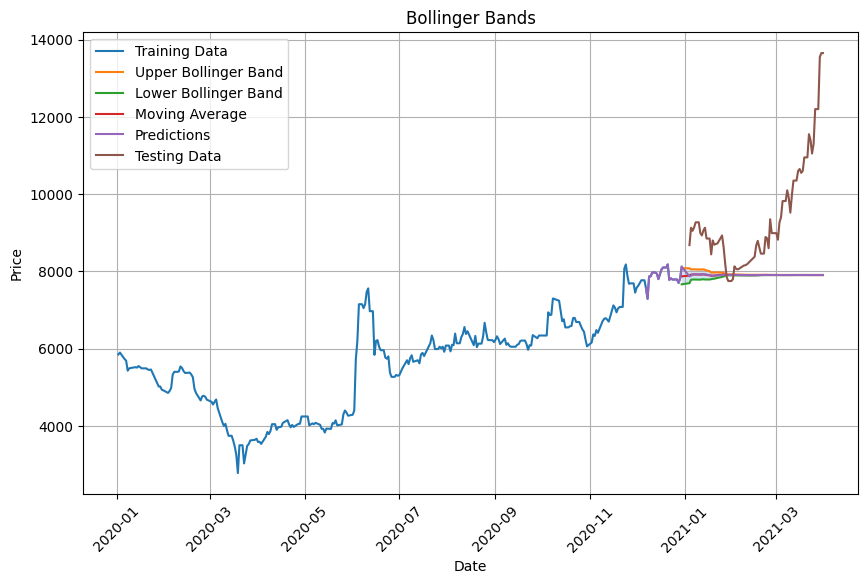

Processing stock data for Company: KCHOL


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


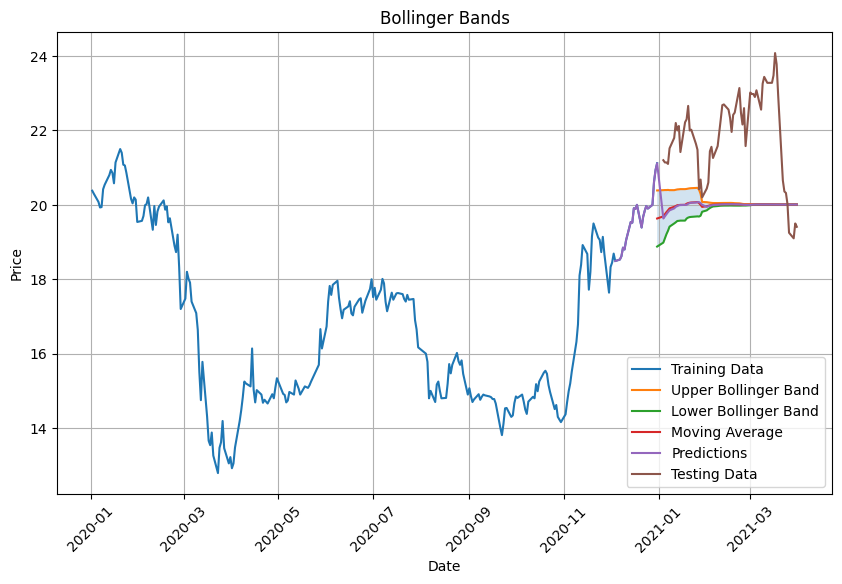

Processing stock data for Company: MNHD


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


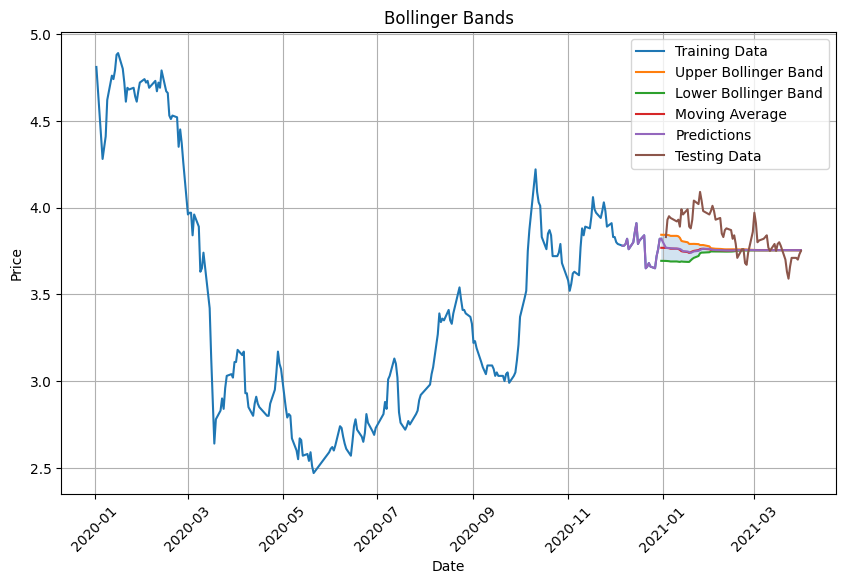

Processing stock data for Company: CCB


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


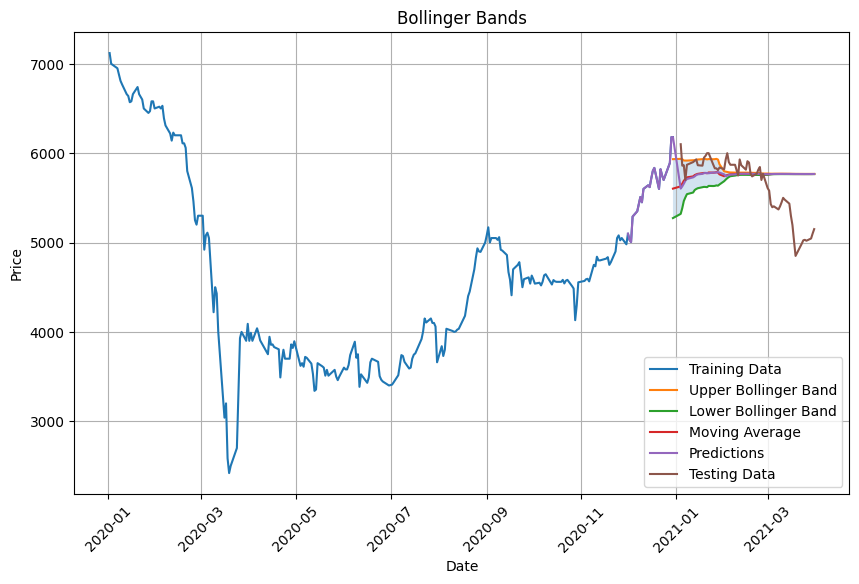

Processing stock data for Company: PAMP


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


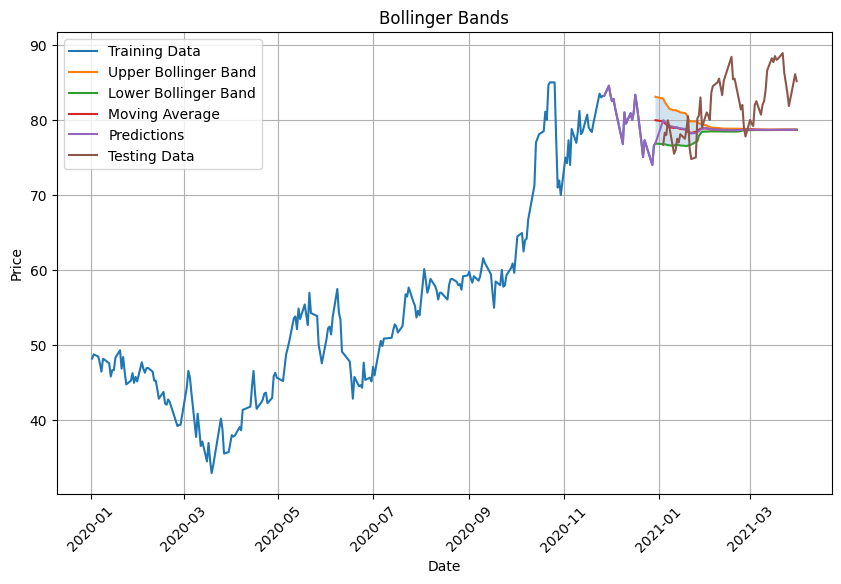

Processing stock data for Company: SBER


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


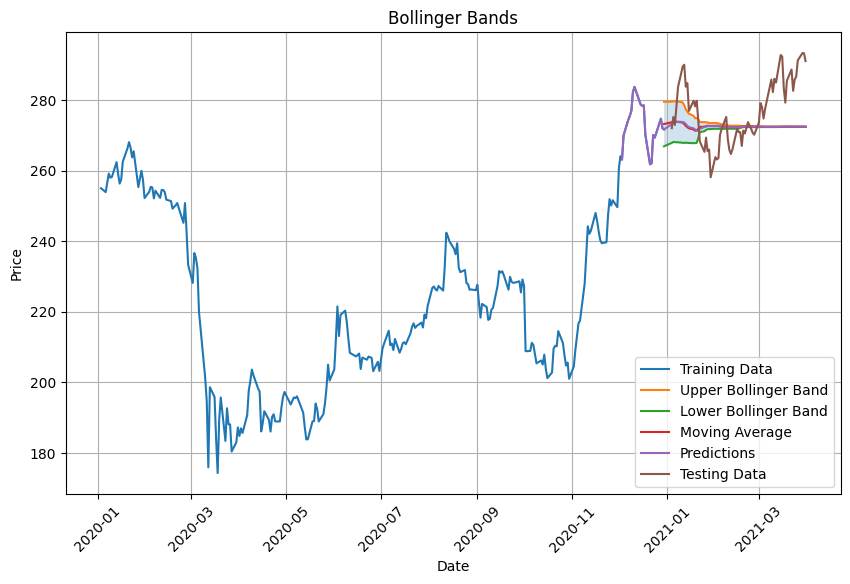

Processing stock data for Company: BEEF3


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


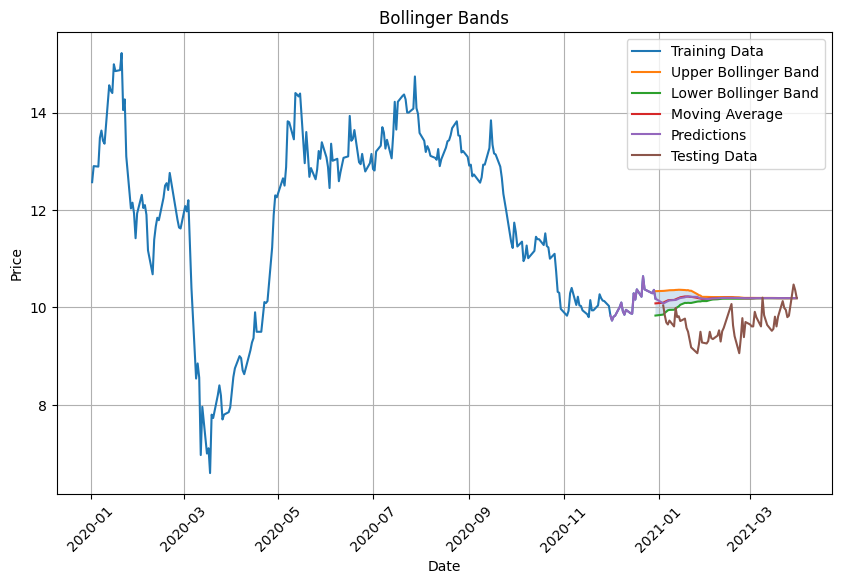

Processing stock data for Company: IMPJ


<ipython-input-47-af6f0b9617eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Price'][window_size:] = predictions


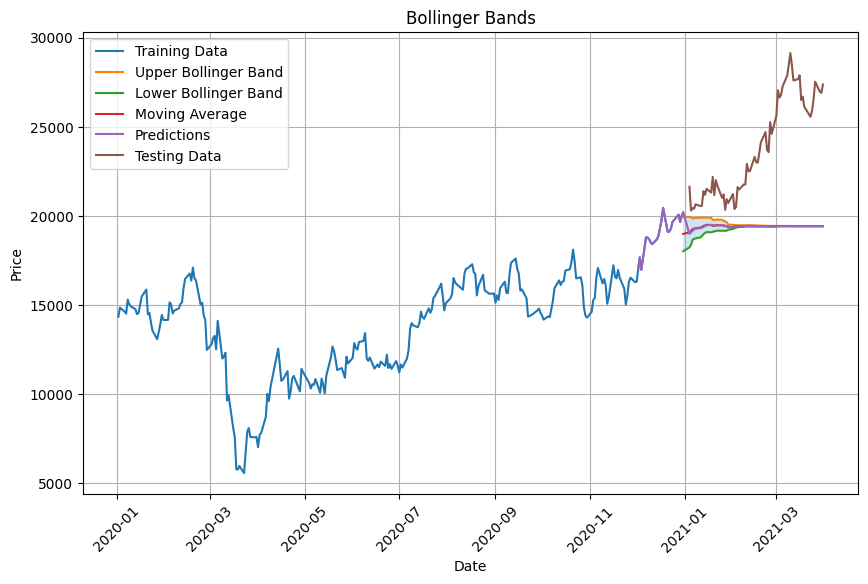

In [50]:
recommendations = {}

for code in stock_dfs:
  df = stock_dfs[code]

  print(f'Processing stock data for Company: {code}')

  idx_2021, time_train, train_set, time_test, test_set = train_test_split(df)
  predictions = pred_MA(train_set, output_length=len(time_test))
  pred_df = generate_predictions_and_recommendations(df, predictions)

  recommendations[code] = pred_df[['Date', 'Price', 'UpperBand', 'LowerBand', 'MA', 'Recommendation']]

Moving Average seem to converge to a single value which makes the recommendations less effective. Let's try it again with prophet.

In [50]:
stock_dfs['001230'][idx_2021:]

,Date,Price,Open,High,Low,Vol.,Change %,date_diff
68,2021-01-04,8680.0,"8,120","8,690","7,990",9.63K,6.90%,369
67,2021-01-05,9130.0,"8,700","9,560","8,640",0.02K,5.18%,370
66,2021-01-06,9050.0,"9,190","9,300","8,870",0.13K,-0.88%,371
65,2021-01-07,9140.0,"9,180","9,410","9,120",0.33K,0.99%,372
64,2021-01-08,9270.0,"9,150","9,470","9,050",2.39M,1.42%,373
...,...,...,...,...,...,...,...,...
4,2021-03-26,12200.0,"11,500","12,300","11,350",2.34M,7.96%,450
3,2021-03-28,12200.0,"12,200","12,200","12,200",-,0.00%,452
2,2021-03-29,13550.0,"12,500","13,800","12,500",0.20K,11.07%,453
1,2021-03-30,13650.0,"13,850","14,200","13,050",3.17M,0.74%,454


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/mdkhzlrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/z6e1ksr7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22866', 'data', 'file=/tmp/tmpj4c7mva_/mdkhzlrl.json', 'init=/tmp/tmpj4c7mva_/z6e1ksr7.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modelcs742ya1/prophet_model-20230629163023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing stock data for Company: 001230


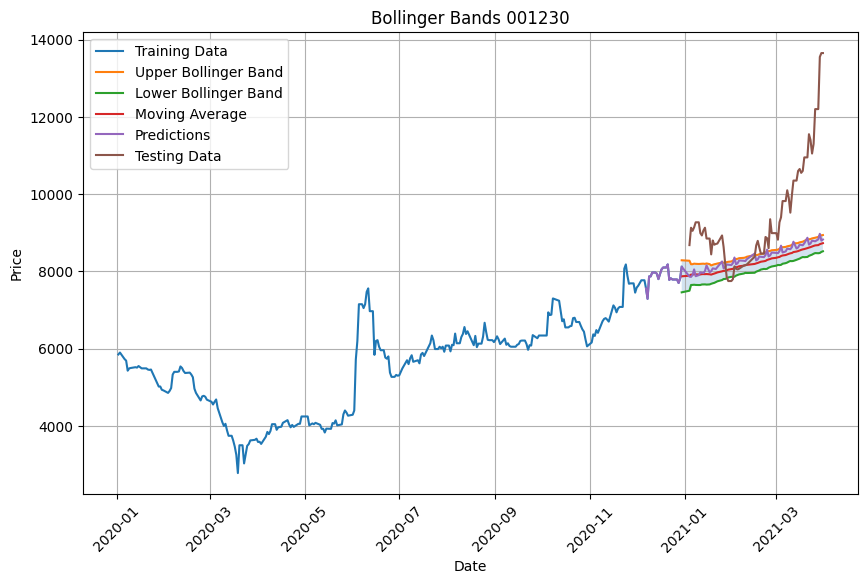

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/zqdd01jz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/094q118r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12766', 'data', 'file=/tmp/tmpj4c7mva_/zqdd01jz.json', 'init=/tmp/tmpj4c7mva_/094q118r.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modelagd6xn_4/prophet_model-20230629163024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing stock data for Company: KCHOL


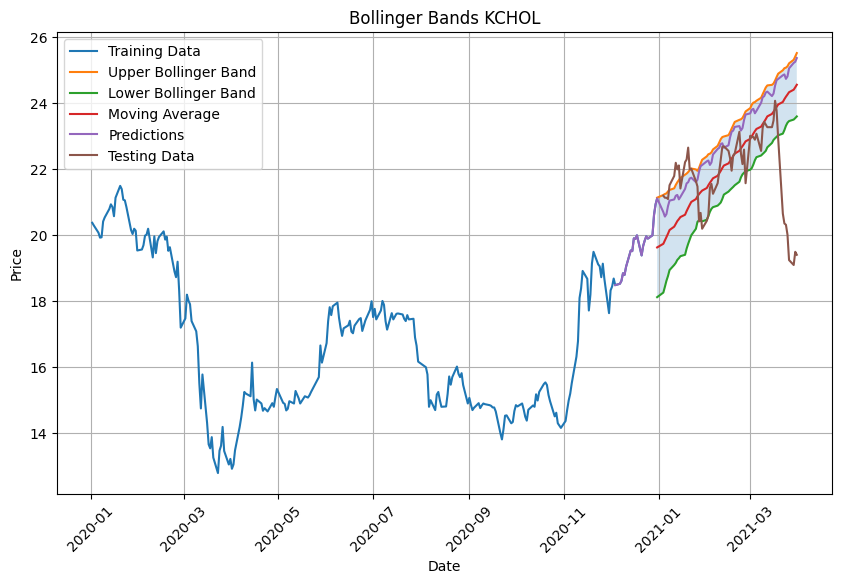

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/hge8jhhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/6ziceteu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65773', 'data', 'file=/tmp/tmpj4c7mva_/hge8jhhw.json', 'init=/tmp/tmpj4c7mva_/6ziceteu.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modelohouq8ey/prophet_model-20230629163025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing stock data for Company: MNHD


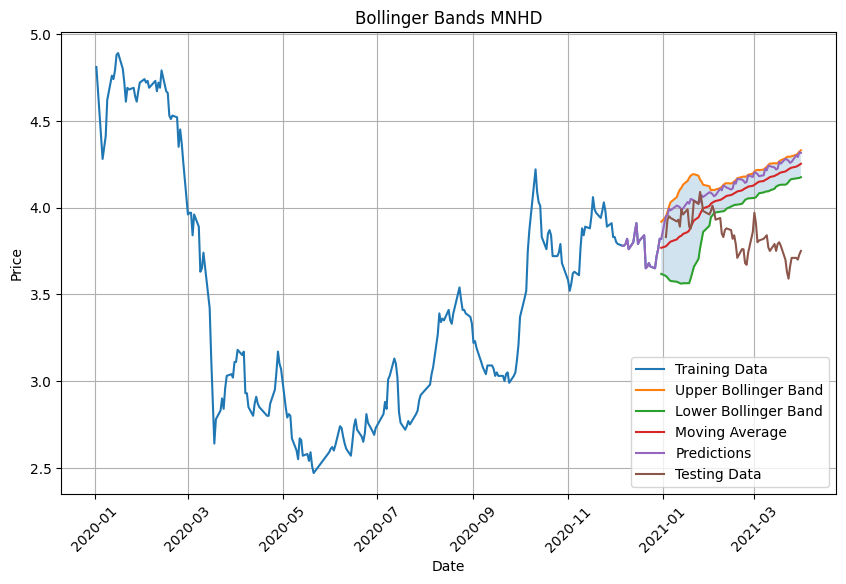

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/qy2xf38p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/cyybekeg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1969', 'data', 'file=/tmp/tmpj4c7mva_/qy2xf38p.json', 'init=/tmp/tmpj4c7mva_/cyybekeg.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modelzmk79nml/prophet_model-20230629163025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing stock data for Company: CCB


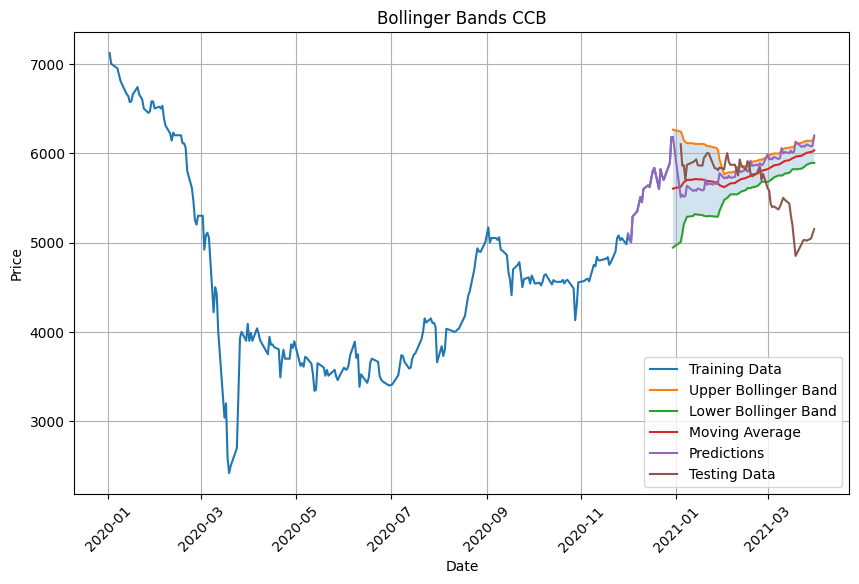

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/0p2fjuxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/3gy7b_0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46167', 'data', 'file=/tmp/tmpj4c7mva_/0p2fjuxk.json', 'init=/tmp/tmpj4c7mva_/3gy7b_0f.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modele1fm1zae/prophet_model-20230629163026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing stock data for Company: PAMP


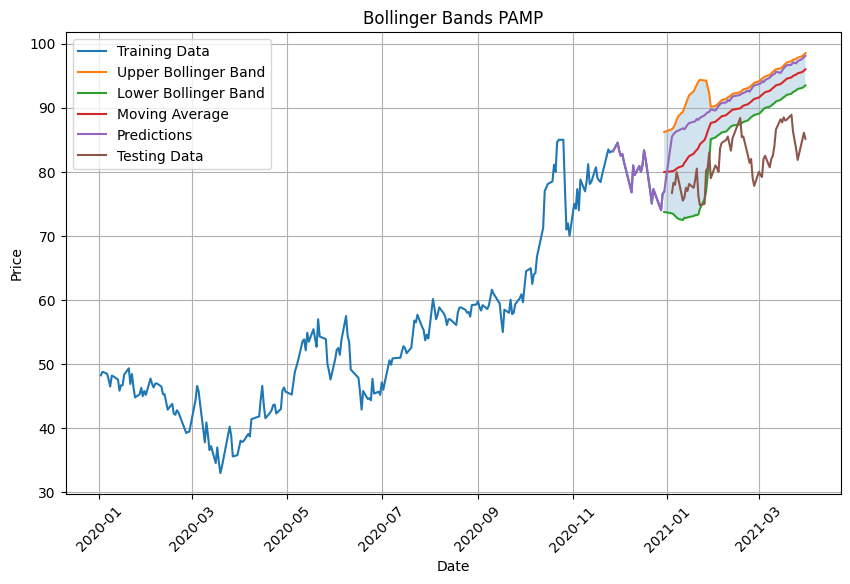

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/3ly0bvfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/7h_81lto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58970', 'data', 'file=/tmp/tmpj4c7mva_/3ly0bvfm.json', 'init=/tmp/tmpj4c7mva_/7h_81lto.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modelun6s8frn/prophet_model-20230629163027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing stock data for Company: SBER


16:30:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


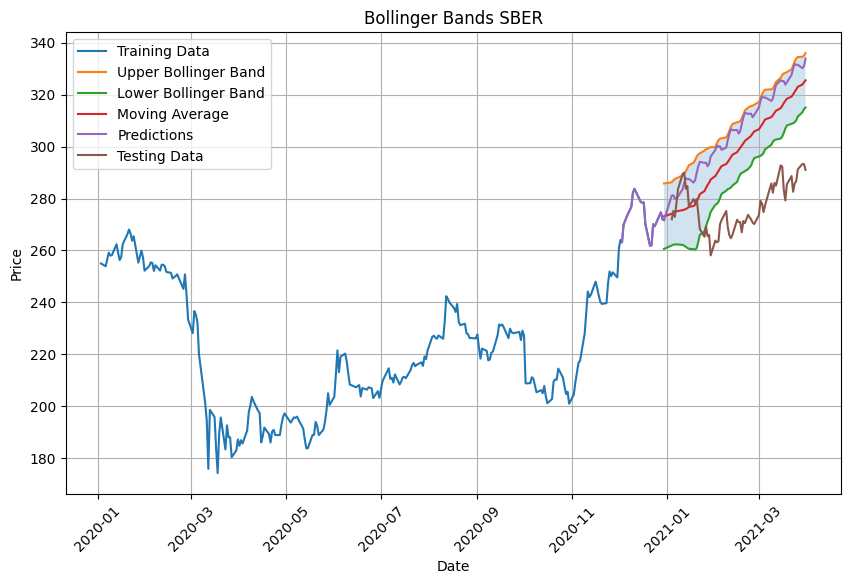

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/i69yoarb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/w2vati4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Processing stock data for Company: BEEF3


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43333', 'data', 'file=/tmp/tmpj4c7mva_/i69yoarb.json', 'init=/tmp/tmpj4c7mva_/w2vati4p.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_modelpe6o9hxv/prophet_model-20230629163029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


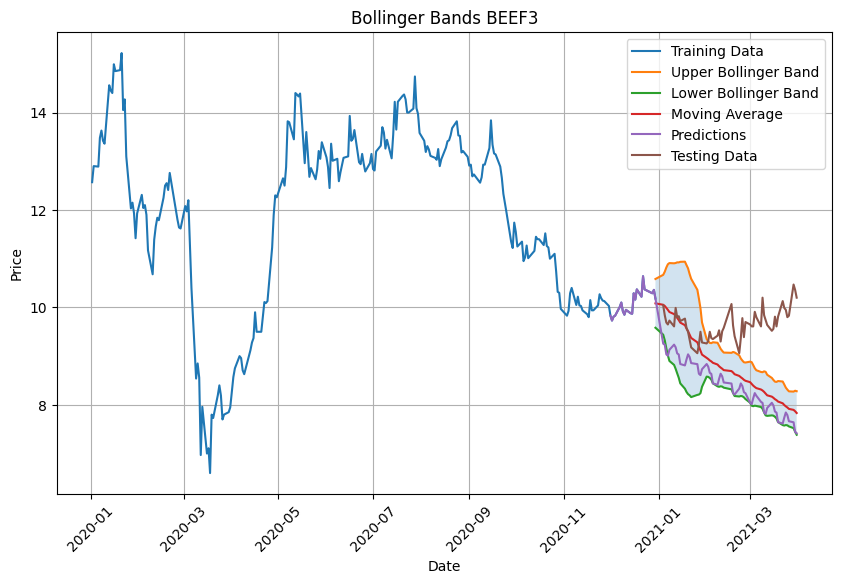

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/2k4xcmly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4c7mva_/c3bb08tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55079', 'data', 'file=/tmp/tmpj4c7mva_/2k4xcmly.json', 'init=/tmp/tmpj4c7mva_/c3bb08tl.json', 'output', 'file=/tmp/tmpj4c7mva_/prophet_model0ut333gq/prophet_model-20230629163030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing stock data for Company: IMPJ


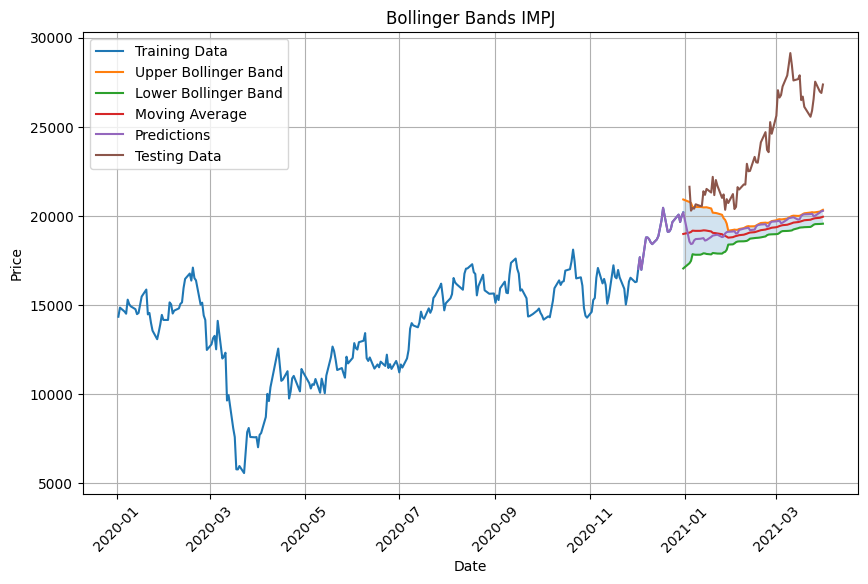

In [65]:
recommendations_prophet = {}

for code in stock_dfs:
  df = stock_dfs[code]

  print(f'Processing stock data for Company: {code}')

  idx_2021, time_train, train_set, time_test, test_set = train_test_split(df)
  _, _, predictions = pred_prophet(df, time_test.shape[0])
  pred_df = generate_predictions_and_recommendations(df, predictions[idx_2021:], code=code)

  recommendations_prophet[code] = pred_df[['Date', 'Price', 'UpperBand', 'LowerBand', 'MA', 'Recommendation']]

In [66]:
recommendations_prophet['IMPJ']

,Date,Price,UpperBand,LowerBand,MA,Recommendation
61,2021-01-04,18548.307655,20775.394704,17335.236061,19055.315383,Sell
60,2021-01-05,18412.387957,20716.106298,17468.663264,19092.384781,Hold
59,2021-01-06,18440.334590,20490.031263,17841.971758,19166.001510,Hold
58,2021-01-07,18617.670015,20493.842539,17821.627483,19157.735011,Hold
57,2021-01-08,18691.445126,20495.276389,17811.138146,19153.207267,Sell
...,...,...,...,...,...,...
4,2021-03-25,19977.395407,20187.202557,19497.339833,19842.271195,Sell
3,2021-03-26,20005.342040,20194.442989,19531.053637,19862.748313,Sell
2,2021-03-29,20182.677464,20236.171181,19540.635714,19888.403447,Sell
1,2021-03-30,20256.452576,20287.785455,19545.854787,19916.820121,Sell


It seems like the model was only able to capture the price changing trend for the last n days and was not able to capture the randomness in 2021 which is expected.